In [1]:
from torchvision import models
from torch import nn
import torch

class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
      
  def forward(self, x):
    return x

def get_vgg_model(num_outputs, init_scale):
  vgg16 = models.vgg16()

  # Remove avgpool since it's removed in the paper
  vgg16.avgpool = Identity()

  # In the paper, VGG16 model's 2 last FC layers are removed
  # Output of last max pool layer is [batch_size,512,7,7] for 224x224 image
  #vgg16.classifier = nn.Linear(512*7*7, num_outputs)

  # For 32x32 image
  vgg16.classifier = nn.Linear(512, num_outputs)

  #for module in vgg16.modules():
  #  if type(module) == nn.modules.pooling.MaxPool2d:
  #    module = nn.MaxPool2d(2, stride=2, padding='same')
    #if "MaxPool2d" is in str(type(module)):
    #  print("module is : {}".format(type(module)))
  # Change weight initialization with a nested function
  def init_weights(param):
    if (type(param) == nn.Conv2d or type(param) == nn.Linear):
      # Parameters are initialized with He initialization in the paper.

      torch.nn.init.kaiming_normal_(param.weight, mode='fan_out', nonlinearity='relu')
      # # ??
      # param.weight = torch.nn.Parameter(param.weight * init_scale)

      # print(type(param.weight))
      # param.weight.data.fill_(param.weight * init_scale)
      # torch.full(param.weight.size(), 3.141592)

      # Default value of biases are already 0, just to be more verbose
      # param.bias.data.fill_(0)

      # print(param)
      # print(type(param))

  vgg16.apply(init_weights)
  return vgg16

In [2]:
# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary

vgg16 = get_vgg_model(13, 1)
# batch_size = 256
print(summary(vgg16, input_size=(1, 3, 32, 32)))
#print(summary(vgg16, input_size=(1, 3, 224, 224)))

# summary(vgg16, input_size=(batch_size, 3, 224, 224))
# summary(models.vgg16(), input_size=(1, 3, 32, 32))
print(vgg16)
#vgg16 = models.vgg16()
#print(vgg16)


# print(vgg16)

# vgg16.apply(init_weights)
# print("dummy")
# for child in vgg16.named_children():
#   # print("x")
#   print(child)

# for name, param in vgg16.named_parameters():
#   print(name)
#   print(param.size())
#   print(param[0])

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └

In [3]:
import torchvision.transforms as transforms
import torchvision
import copy
import numpy as np

def get_cifar10_sets(num_examples_upstream, num_examples_downstream, num_classes_upstream, \
                     num_classes_downstream, is_downstream_random, batch_size):
  # @TODO: Check if it's the same as paper
  TF = transforms.Compose([
      #transforms.Resize(256),
      #transforms.CenterCrop(224),
      transforms.ToTensor(),
      # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

  # num_examples_upstream = 20000
  # num_examples_downstream = 10000
  # num_classes_upstream = 30
  # num_classes_downstream = 15
  # is_downstream_random = False

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=TF)
  # test and transform??
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=TF)

  # Create random indices for splitting upstream and downstream tasks
  indices = np.arange(0,len(trainset))
  np.random.seed(12345)
  np.random.shuffle(indices)
  indices = indices.tolist()

  # Make upstream labels random
  temp = np.array(trainset.targets)
  temp[indices[:num_examples_upstream]] = np.random.randint(num_classes_upstream, size=num_examples_upstream)

  # If the downstream task uses random labels
  if is_downstream_random:
    temp[indices[-num_examples_downstream:]] = np.random.randint(num_classes_downstream, size=num_examples_downstream).tolist()

  trainset.targets = [int(label) for label in temp]

  # Build dataloaders for upstream and downstream tasks
  train_upstream_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False,
                                                sampler=torch.utils.data.SubsetRandomSampler(indices[:num_examples_upstream]))

  train_downstream_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False,
                                                sampler=torch.utils.data.SubsetRandomSampler(indices[-num_examples_downstream:]))

  test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

  # To check the random labels
  '''
  u_batch = next(iter(train_upstream_loader))
  d_batch = next(iter(train_downstream_loader))

  u_labels = u_batch[1]
  print(u_labels)
  d_labels = d_batch[1]
  print(d_labels)
  '''
  return (train_upstream_loader, train_downstream_loader, test_loader)


def get_cifar10_orig():
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  batch_size = 256


  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=False, transform=transform)
  indices = np.arange(0,len(trainset))
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=False, num_workers=2, 
                                            sampler=torch.utils.data.SubsetRandomSampler(indices[:5000]))

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=False, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  return trainloader

In [4]:
def accuracy(model, data="train"):
  correct = 0
  total = 0

  if data== "train":
    _, dataloader, __ = get_cifar10_sets(
        num_examples_upstream = 5000,
        num_examples_downstream = 20000,
        num_classes_upstream = 5,
        num_classes_downstream = 10,  
        is_downstream_random = False,
        batch_size = 20000
    )
  elif data == "test":
    _, __, dataloader = get_cifar10_sets(
        num_examples_upstream = 5000,
        num_examples_downstream = 20000,
        num_classes_upstream = 5,
        num_classes_downstream = 10,  
        is_downstream_random = False,
        batch_size = 10000
    )
  else:
    print("choose a proper data mode")
    return
  with torch.no_grad():
    for data in dataloader:
      inputs, labels = data
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return (correct / total)

def train(model, criterion, optimizer, epochs, dataloader, device, scheduler=None, acc_mode="none", verbose=True):
  loss_history = []
  train_accuracies = []
  test_accuracies = []
  for epoch in range(1,epochs+1):
    count = 0
    for i, data in enumerate(dataloader, 0):     
      # print("{}.th batch".format(i))
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      # print("batching!")

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()
      # print("zero grad!")

      # Obtain the scores
      outputs = model(inputs)
      # print("feedforward!")

      # Calculate loss
      loss = criterion(outputs.to(device), labels)
      # print("loss!")

      # Backpropagate
      loss.backward()
      # print("backward!")

      # Update the weights
      optimizer.step()
      # print("update!")
      
      loss_history.append(loss.item())
      count += 1
      #print("mini batch counter: {}".format(count))
      if (count % 15 == 0):
          if acc_mode=="both":
            train_acc = accuracy(model, data="train")
            train_accuracies.append(train_acc)
            test_acc = accuracy(model, data="test")
            test_accuracies.append(test_acc)
          elif acc_mode=="train":
            train_acc = accuracy(model, data="train")
            train_accuracies.append(train_acc)
          elif acc_mode=="test":
            test_acc = accuracy(model, data="test")
            test_accuracies.append(test_acc)
    
    if verbose: 
        print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')
        if acc_mode=="train" or acc_mode =="both":
          print(f'Epoch {epoch} / {epochs}: Last train acc:{train_acc}')
        if acc_mode=="test" or acc_mode =="both":
          print(f'Epoch {epoch} / {epochs}: Last test acc:{test_acc}')

    if scheduler is not None:
      scheduler.step()
      # Print Learning Rate
      print('Epoch:', epoch,'LR:', scheduler.get_last_lr())

  if acc_mode=="both":
    return loss_history, train_accuracies, test_accuracies
  elif acc_mode=="train":
    return loss_history, train_accuracies
  elif acc_mode=="test":
    return loss_history, test_accuracies
  return loss_history


In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def get_training_components(learnable_params, init_lr, step_size):
  '''
  Function to prepare components of the training. These are all the same
  throughout the experiments made.
  '''
  # The problem always be a image classification
  criterion = nn.CrossEntropyLoss()
  # Which parameters to be updated depends on if the training is done from scratch
  # or with pre-trained model.
  optimizer = optim.SGD(learnable_params, lr=init_lr, momentum=0.9)
  # Step size depends on the # of epoch, gamma is contant
  scheduler = StepLR(optimizer, step_size=step_size, gamma=1/3)
  return (criterion, optimizer, scheduler)

def get_device():
  if torch.cuda.is_available():
    print("Cuda (GPU support) is available and enabled!")
    device = torch.device("cuda")
  else:
    print("Cuda (GPU support) is not available :(")
    device = torch.device("cpu")

def get_learnable_parameters(model):
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      #print(name)
      params_to_update.append(param)
  return params_to_update


In [6]:
from torch import linalg as LA

train_upstream_loader, train_downstream_loader, test_loader = get_cifar10_sets(
    num_examples_upstream = 20000,
    num_examples_downstream = 20000,
    num_classes_upstream = 5,
    num_classes_downstream = 5,
    is_downstream_random = False,
    batch_size = 256
  )

model = get_vgg_model(5, 1)
norm_dict = {}
for name, param in model.named_parameters():
  norm_dict[name] = LA.norm(param)

epochs = 120
learnable_parameters = get_learnable_parameters(model)
criterion, optimizer, scheduler = get_training_components(learnable_parameters, 0.001, (int)(epochs/3))

device = get_device()
model = model.to(device)
model.train()
loss_history = train(model, criterion, optimizer, epochs, train_upstream_loader, device, scheduler=scheduler)

# scale norms back to initial values after upstream training
for name, param in model.named_parameters():
  scale = norm_dict[name]
  param.data.copy_(param*(scale.item()/LA.norm(param)))

torch.save(model.state_dict(), "./pretrained_model_dict_upstream_1_2.pt")
torch.save(model, "./pretrained_model_upstream_1_2.pt")


Cuda (GPU support) is available and enabled!
Epoch 1 / 120: avg. loss of last 5 iterations 1.6133390665054321
Epoch: 1 LR: [0.001]
Epoch 2 / 120: avg. loss of last 5 iterations 1.6077460765838623
Epoch: 2 LR: [0.001]
Epoch 3 / 120: avg. loss of last 5 iterations 1.605721402168274
Epoch: 3 LR: [0.001]
Epoch 4 / 120: avg. loss of last 5 iterations 1.6093560218811036
Epoch: 4 LR: [0.001]
Epoch 5 / 120: avg. loss of last 5 iterations 1.6039263248443603
Epoch: 5 LR: [0.001]
Epoch 6 / 120: avg. loss of last 5 iterations 1.5962279558181762
Epoch: 6 LR: [0.001]
Epoch 7 / 120: avg. loss of last 5 iterations 1.606328511238098
Epoch: 7 LR: [0.001]
Epoch 8 / 120: avg. loss of last 5 iterations 1.5934141874313354
Epoch: 8 LR: [0.001]
Epoch 9 / 120: avg. loss of last 5 iterations 1.5921808719635009
Epoch: 9 LR: [0.001]
Epoch 10 / 120: avg. loss of last 5 iterations 1.5870641946792603
Epoch: 10 LR: [0.001]
Epoch 11 / 120: avg. loss of last 5 iterations 1.585596537590027
Epoch: 11 LR: [0.001]
Epoch 12

In [7]:
def setup_and_train_downstream(epochs, lr, step_size, num_examples_upstream, num_examples_downstream,
                   num_classes_upstream, num_classes_downstream, is_downstream_random,
                   batch_size, num_outputs, upstream_model_path=None):
    
    train_upstream_loader, train_downstream_loader, test_loader = get_cifar10_sets(
        num_examples_upstream, num_examples_downstream, num_classes_upstream,
        num_classes_downstream, is_downstream_random, batch_size)

    model = get_vgg_model(num_classes_downstream, 1)
    if upstream_model_path is not None:
        model.load_state_dict(torch.load(upstream_model_path), strict=False)
        model.classifier = nn.Linear(512, num_outputs)
        torch.nn.init.kaiming_normal_(model.classifier.weight, mode='fan_out', nonlinearity='relu')

    learnable_parameters = get_learnable_parameters(model)
    criterion, optimizer, scheduler = get_training_components(learnable_parameters, lr, step_size)
    device = get_device()
    model = model.to(device)
    model.train()
    if not is_downstream_random:
      loss_history, train_accuracies, test_accuracies = train(model, criterion, optimizer, epochs, train_downstream_loader, 
                                                              device, scheduler=scheduler, acc_mode="both")
      return loss_history, train_accuracies, test_accuracies
    loss_history, train_accuracies = train(model, criterion, optimizer, epochs, train_downstream_loader, 
                                           device, scheduler=scheduler, acc_mode="train")
    return loss_history, train_accuracies

In [8]:
# From scratch with real labels
loss_scratch_real, accs_scratch_real_train, accs_scratch_real_test = setup_and_train_downstream(
    epochs=40, lr=0.001, step_size=(int)(40/3), num_examples_upstream=20000, 
    num_examples_downstream=20000, num_classes_upstream = 5, num_classes_downstream = 10,
    is_downstream_random = False, batch_size = 256, num_outputs=10
)



Cuda (GPU support) is available and enabled!
Epoch 1 / 40: avg. loss of last 5 iterations 1.9065651416778564
Epoch 1 / 40: Last train acc:0.29745
Epoch 1 / 40: Last test acc:0.3024
Epoch: 1 LR: [0.001]
Epoch 2 / 40: avg. loss of last 5 iterations 1.6211234331130981
Epoch 2 / 40: Last train acc:0.42845
Epoch 2 / 40: Last test acc:0.428
Epoch: 2 LR: [0.001]
Epoch 3 / 40: avg. loss of last 5 iterations 1.5648954391479493
Epoch 3 / 40: Last train acc:0.42495
Epoch 3 / 40: Last test acc:0.4159
Epoch: 3 LR: [0.001]
Epoch 4 / 40: avg. loss of last 5 iterations 1.3323709487915039
Epoch 4 / 40: Last train acc:0.51525
Epoch 4 / 40: Last test acc:0.4925
Epoch: 4 LR: [0.001]
Epoch 5 / 40: avg. loss of last 5 iterations 1.3845954179763793
Epoch 5 / 40: Last train acc:0.5284
Epoch 5 / 40: Last test acc:0.5056
Epoch: 5 LR: [0.001]
Epoch 6 / 40: avg. loss of last 5 iterations 1.308006715774536
Epoch 6 / 40: Last train acc:0.5417
Epoch 6 / 40: Last test acc:0.5077
Epoch: 6 LR: [0.001]
Epoch 7 / 40: avg

In [9]:
# Using upstream training's weights with real labels
loss_upstream_real, accs_upstream_real_train, accs_upstream_real_test = setup_and_train_downstream(
    epochs=40, lr=0.001, step_size=(int)(40/3), num_examples_upstream=20000, 
    num_examples_downstream=20000, num_classes_upstream = 5, num_classes_downstream = 5,
    is_downstream_random = False, batch_size = 256, num_outputs=10,
    upstream_model_path = "pretrained_model_dict_upstream_1_2.pt"
)


Cuda (GPU support) is available and enabled!
Epoch 1 / 40: avg. loss of last 5 iterations 1.8364093780517579
Epoch 1 / 40: Last train acc:0.35295
Epoch 1 / 40: Last test acc:0.3466
Epoch: 1 LR: [0.001]
Epoch 2 / 40: avg. loss of last 5 iterations 1.5792887926101684
Epoch 2 / 40: Last train acc:0.44275
Epoch 2 / 40: Last test acc:0.4279
Epoch: 2 LR: [0.001]
Epoch 3 / 40: avg. loss of last 5 iterations 1.4937051296234132
Epoch 3 / 40: Last train acc:0.49845
Epoch 3 / 40: Last test acc:0.466
Epoch: 3 LR: [0.001]
Epoch 4 / 40: avg. loss of last 5 iterations 1.3794410705566407
Epoch 4 / 40: Last train acc:0.5465
Epoch 4 / 40: Last test acc:0.4972
Epoch: 4 LR: [0.001]
Epoch 5 / 40: avg. loss of last 5 iterations 1.3808815956115723
Epoch 5 / 40: Last train acc:0.54975
Epoch 5 / 40: Last test acc:0.4885
Epoch: 5 LR: [0.001]
Epoch 6 / 40: avg. loss of last 5 iterations 1.1478238105773926
Epoch 6 / 40: Last train acc:0.61995
Epoch 6 / 40: Last test acc:0.5242
Epoch: 6 LR: [0.001]
Epoch 7 / 40: a

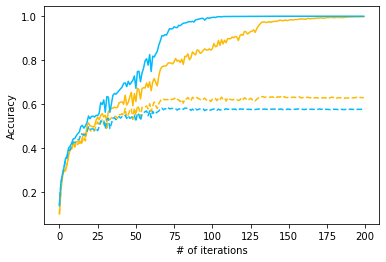

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

orange = "#fcba03" # from scr
light_blue = "#03bafc" # pre

plt.plot(accs_scratch_real_train, linestyle="-", color=orange)
plt.plot(accs_upstream_real_train, linestyle="-", color=light_blue)
plt.plot(accs_scratch_real_test, linestyle="--", color=orange)
plt.plot(accs_upstream_real_test, linestyle="--", color=light_blue)
plt.xlabel('# of iterations')
plt.ylabel('Accuracy')
plt.show()